### First enter your login username and password. 

We prompt for the password so that you do not have to enter your credentials directly in the notebook as plain text.

These credentials will be used to access Azure Data Lake credentials that are secured by Hashicorp Vault.  

In [1]:
import getpass
(username, password) = getpass.getpass(prompt='Login Username/Password: ', stream=None).split('/')

Login Username/Password:  ··············


### Install the python library for Hashicorp Vault services.  

Use the login username and password to retrieve the Azure data lake credentials that were created directly using the vault CLI tools (the Vault Web UI could have been used instead).

In [3]:
! pip3 install --user hvac --quiet

In [4]:
from hvac import Client

client = Client(url='http://10.1.0.183:8200', verify=False)
client.auth_userpass(username, password, mount_point='userpass', use_token=True)
print('Authenticated: ' + str(client.is_authenticated()))

Authenticated: True


In [5]:
secret_version_response = client.secrets.kv.v2.read_secret_version(path='azure_datalake')
account_name = secret_version_response['data']['data']['accountName']
account_key = secret_version_response['data']['data']['accountKey']

### Install the python library for azure data lake and retrieve a dataset for analysis

In [7]:
! pip3 install --user azure-storage-blob --quiet

In [8]:
from azure.storage.blob import BlockBlobService

block_blob_service = BlockBlobService(account_name=account_name, account_key=account_key)

In [9]:
_ = block_blob_service.get_blob_to_path('mycontainer', 'boston_house_prices.csv', 'boston_house_prices.csv')

### Load the data and build a model using Scikit-learn

In [10]:
! pip install --user scikit-learn --quiet
! pip install --user matplotlib --quiet
! pip install --user numpy --quiet

In [11]:
import numpy as np

f = open("boston_house_prices.csv")
f.readline()
data = np.loadtxt(f, delimiter = ',')

X = data[:, 0:-1] 
y = data[:, -1] 

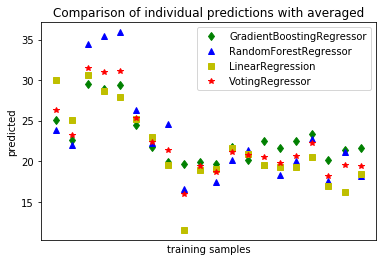

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)
ereg.fit(X, y)

xt = X[:20]

plt.figure()
plt.plot(reg1.predict(xt), 'gd', label='GradientBoostingRegressor')
plt.plot(reg2.predict(xt), 'b^', label='RandomForestRegressor')
plt.plot(reg3.predict(xt), 'ys', label='LinearRegression')
plt.plot(ereg.predict(xt), 'r*', label='VotingRegressor')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()